#   FileName: setupData.py
##  Author: Toluwanimi Odemuyiwa
### Date: May 2020
### Description: This sets up the data for the volume rendering process. Mainly it does the following:
            1. loads in volumetric data
            2. determines the gradient values at each voxel/data point using a nearest voxel approach
### Implementation notes:
            1. Gradient values take advantage of the GPU by programming in Pythonic CUDA (using the numba library)

In [1]:
##All the imports
import numba
from numba import cuda

#from ipynb.fs.full.readRaw import readVolume
import json
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors


from sklearn.cluster import AffinityPropagation 
from sklearn import metrics 

import timeit

In [2]:
def ParseJSON(fname):
    contents = dict()
    # Opening JSON file -- used this as reference: https://www.geeksforgeeks.org/convert-json-to-dictionary-in-python/
    with open(fname) as json_file: 
        contents = json.load(json_file) 

        # Print the type of data variable 
        print("Type:", type(contents)) 


    #Store the information
    volumeInfo = {}
    volumeInfo['name']    = contents["name"]
    volumeInfo['type']    = contents["type"]
    volumeInfo['size']    = contents["size"]
    volumeInfo['spacing'] = contents["spacing"]
    volumeInfo['fname']   = os.path.basename(contents["url"])
    
    
    ##This uses code from here: https://stackoverflow.com/questions/1124810/how-can-i-find-path-to-given-file
    for root, dirs, files in os.walk(r'../../'):
        for name in files:
            if name == volumeInfo['fname']:
                print(os.path.abspath(os.path.join(root, name)))
                volumeInfo['dpath']   = os.path.abspath(os.path.join(root, name))


    print(volumeInfo)
    return volumeInfo

##number of bytes for a datatype
def SizeOf(dataType):

    if (dataType == "uchar"):
        return 1
    if (dataType == "char"):
        return 1
    if (dataType == "uint8"):
        return 1
    if (dataType == "uint16"):
        return 2
    if (dataType == "uint32"):
        return 4
    if (dataType == "uint64"):
        return 8
    if (dataType == "int8"):
        return 1
    print("Error: Unrecognized type", dataType)



def ParseRaw(volumeInfo):
    print(volumeInfo['type'])
    voxel_size = SizeOf(volumeInfo['type'])
    nbytes_per_line = volumeInfo['size'][0] * voxel_size
    num_of_lines    = volumeInfo['size'][1] * volumeInfo['size'][2]
    fname = volumeInfo['dpath']
    
    ##this is hardcoded to int values
    data_ptr = np.zeros(volumeInfo['size'], dtype = np.int)

    
    print("Reading the RAW file")
    
    file = open(fname, "rb") ##it's a binary file
    
    for line in range(num_of_lines):
        #print("\n\n", [char for char in file.read(nbytes_per_line)])
        y_idx = line % nbytes_per_line
        z_idx = line // volumeInfo['size'][1]
        #print(line, y_idx, z_idx)
        data_ptr[:][y_idx][z_idx] = [char for char in file.read(nbytes_per_line)]
        
    file.close()
    return data_ptr

def readVolume(fname):
    volumeInfo = ParseJSON(fname)
    data_ptr   = ParseRaw(volumeInfo)
    return data_ptr, volumeInfo

In [3]:
def iDivUp(a, b):
    val = (a / b + 1) if  (a % b != 0) else (a / b);
    return int(val)

In [4]:
#Time to do gradient calculation
@cuda.jit
def setGradients(data_ptr, grad_ptr, grad_mag_ptr, data_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    if (i == 0):
        x = ((data_ptr[i+1][j][k]) - (data_ptr[i][j][k]) )  / 1
    elif (i == (x_size -1)):
        x = ((data_ptr[i][j][k])   - (data_ptr[i-1][j][k])) / 1
    else:
        x = (data_ptr[i+1][j][k]   - data_ptr[i-1][j][k])   / 2
    
    if (j == 0):
        y = ((data_ptr[i][j+1][k]) - (data_ptr[i][j][k]) )  / 1
    elif (j == (x_size -1)):
        y = ((data_ptr[i][j][k])   - (data_ptr[i][j-1][k])) / 1
    else:
        y = (data_ptr[i][j+1][k]   - data_ptr[i][j-1][k])   / 2
    
    if (k == 0):
        z = ((data_ptr[i][j][k+1]) - (data_ptr[i][j][k]) )  / 1
    elif (k == (x_size -1)):
        z = ((data_ptr[i][j][k])   - (data_ptr[i][j][k-1])) / 1
    else:
        z = (data_ptr[i][j][k+1]   - data_ptr[i][j][k-1])   / 2    

    grad_ptr[i][j][k][0] = x;
    grad_ptr[i][j][k][1] = y;
    grad_ptr[i][j][k][2] = z;
    grad_mag_ptr[i][j][k] = math.sqrt(pow(x, 2) + pow(y, 2) + pow(z, 2))
    
    
    
def setGradientsCPU(data_ptr, data_size):
    grad_ptr = np.zeros([data_size[0], data_size[1], data_size[2], 3],  dtype = np.float32)
    grad_mag_ptr = np.zeros([data_size[0], data_size[1], data_size[2]], dtype = np.float32)
   
    #Figure out launch configuration
    blockSize = 8, 8, 8
    gridSize  = iDivUp(data_size[0], 8), iDivUp(data_size[1], 8), iDivUp(data_size[2], 8)
    
    setGradients[gridSize, blockSize](data_ptr, grad_ptr, grad_mag_ptr, data_size)

    cuda.synchronize()
    
    return grad_ptr, grad_mag_ptr
    
    

In [5]:
##Load in the data
fname = "../data/bonsai.json"
data_ptr, volumeInfo = readVolume(fname)
data_size = np.asarray(volumeInfo['size'])
grad_ptr, grad_mag_ptr = setGradientsCPU(data_ptr, data_size)

#print(grad_ptr)

Type: <class 'dict'>
/home/toodemuy/projects/dvrTFGen/DVRTransferFunctionGenerator/data/bonsai_256x256x256_uint8.raw
{'name': 'Bonsai', 'type': 'uint8', 'size': [256, 256, 256], 'spacing': [1, 1, 1], 'fname': 'bonsai_256x256x256_uint8.raw', 'dpath': '/home/toodemuy/projects/dvrTFGen/DVRTransferFunctionGenerator/data/bonsai_256x256x256_uint8.raw'}
uint8
Reading the RAW file


In [6]:
## Generate the IGM Plot
#1. Determine the min/max of intensities
fval_min = data_ptr.min()
fval_max = data_ptr.max()
fval_range = fval_max - fval_min

print(fval_min, fval_max, fval_range)

#2. Determine the min/max of gradients
gval_min = grad_mag_ptr.min()
gval_max = grad_mag_ptr.max()
gval_range = gval_max - gval_min

print(gval_min, gval_max, gval_range)


0 255 255
0.0 140.15973 140.15973


In [7]:
f_num_bins = int(fval_range)
g_num_bins = int(gval_range)
f_bin_size = int(fval_range/f_num_bins)
g_bin_size = int(gval_range/g_num_bins)

if f_bin_size == 0:
    f_bin_size = 1
    
if g_bin_size == 0:
    g_bin_size = 1
    
print(f_bin_size, g_bin_size)

1 1


In [8]:
@cuda.jit
def populateIGM(data_ptr, grad_mag_ptr, data_bin_ptr, data_size, igm_bins, f_bin_size,
                g_bin_size, f_bin_min, g_bin_min, f_num_bins, igm_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    f_val = data_ptr[i][j][k] - f_bin_min
    g_val = grad_mag_ptr[i][j][k] - g_bin_min
    
    f_loc = int(f_val/f_bin_size)
    g_loc = int(g_val/g_bin_size)
      
    idx = f_loc + f_num_bins*g_loc
    
    pos = cuda.atomic.add(igm_bins, idx, 1)
    data_bin_ptr[i][j][k] = pos


@cuda.jit
##This function accumulates the positions so we can calculate the mean
def setupIGMMean(data_ptr, grad_mag_ptr, data_size, igm_bins, mean_arr, f_bin_size,
                    g_bin_size, f_bin_min, g_bin_min, f_num_bins, igm_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    f_val = data_ptr[i][j][k] - f_bin_min
    g_val = grad_mag_ptr[i][j][k] - g_bin_min
    
    f_loc = int(f_val/f_bin_size)
    g_loc = int(g_val/g_bin_size)
      
    idx = f_loc + f_num_bins*g_loc
    
    pos = float(pow(i, 2)  + pow(j, 2) + pow(k, 2))
    pos = math.sqrt(pos)
    
    cuda.atomic.add(mean_arr, idx, pos)   
    
@cuda.jit
##This function accumulates the positions so we can calculate the mean
def setupIGMVariance(data_ptr, grad_mag_ptr, data_size, igm_bins, mean_arr, var_arr, f_bin_size,
                    g_bin_size, f_bin_min, g_bin_min, f_num_bins, igm_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    f_val = data_ptr[i][j][k] - f_bin_min
    g_val = grad_mag_ptr[i][j][k] - g_bin_min
    
    f_loc = int(f_val/f_bin_size)
    g_loc = int(g_val/g_bin_size)
      
    idx = f_loc + f_num_bins*g_loc
    
    pos = float(pow(i, 2)  + pow(j, 2) + pow(k, 2))
    pos = math.sqrt(pos)
    this_var = abs(pos - mean_arr[idx])
    
    cuda.atomic.add(var_arr, idx, this_var)   
    
@cuda.jit    
def calcMean(igm_bins, mean_arr, igm_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    
    if (i >= igm_size):
        return
    
    num_items = igm_bins[i]
    mean_arr[i] = mean_arr[i]/num_items

@cuda.jit
def refineIGM(igm_bins, igm_refined, var_arr, igm_size, threshold):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    
    if (i >= igm_size):
        return
    
    ##If the variance is higher than the threshold,
    ##zero out the bin
    if (var_arr[i] > threshold):
        igm_refined[i] = 0
    else:
        igm_refined[i] = igm_bins[i]
        

In [9]:
def setupIGMHistogram(data_ptr, grad_mag_ptr, data_size, threshold = 1, 
                    f_num_bins = None, g_num_bins = None):
    ## Generate the IGM Plot
    #1. Determine the min/max of intensities
    fval_min = data_ptr.min()
    fval_max = data_ptr.max()
    fval_range = fval_max - fval_min

    print(fval_min, fval_max, fval_range)

    #2. Determine the min/max of gradients
    gval_min = grad_mag_ptr.min()
    gval_max = grad_mag_ptr.max()
    gval_range = gval_max - gval_min

    print(gval_min, gval_max, gval_range)
    
    if f_num_bins is None:
        f_num_bins = int(fval_range)+1
    if g_num_bins is None:
        g_num_bins = int(gval_range)+1
        
    f_bin_size = int((fval_range+1)/f_num_bins)
    g_bin_size = int((gval_range+1)/g_num_bins)

    if f_bin_size == 0:
        f_bin_size = 1

    if g_bin_size == 0:
        g_bin_size = 1

    print("bin sizes", f_bin_size, g_bin_size, "num bins:", f_num_bins, g_num_bins)
    
    igm_size = f_num_bins*g_num_bins
    igm_bins    = np.zeros(f_num_bins*g_num_bins, dtype = np.int)
    igm_refined = np.zeros(f_num_bins*g_num_bins, dtype = np.int)
    
    ##This stores the index of when it added itself to its bin
    data_bin_ptr =  np.zeros([data_size[0], data_size[1], data_size[2]], dtype = np.int)

    
    mean_arr = np.zeros(f_num_bins*g_num_bins, dtype = np.float32)
    var_arr  = np.zeros(f_num_bins*g_num_bins, dtype = np.float32)

    #Figure out launch configuration
    blockSize = 8, 8, 8
    gridSize  = iDivUp(data_size[0], 8), iDivUp(data_size[1], 8), iDivUp(data_size[2], 8)
    
    populateIGM[gridSize, blockSize](data_ptr, grad_mag_ptr, data_bin_ptr, data_size, igm_bins, f_bin_size,
                                     g_bin_size, fval_min, gval_min, f_num_bins, f_num_bins*g_num_bins)
    cuda.synchronize()
    
    #Time to refine the IGM
    #First calculate the mean of each bin
    setupIGMMean[gridSize, blockSize](data_ptr, grad_mag_ptr, data_size, igm_bins, mean_arr, f_bin_size,
                    g_bin_size, fval_min, gval_min, f_num_bins, f_num_bins*g_num_bins)
    cuda.synchronize()
    
    calcMean[iDivUp(igm_size, 256), 256](igm_bins, mean_arr, igm_size)
    cuda.synchronize()
    
    
    ##Now the variance of each bin
    setupIGMVariance[gridSize, blockSize](data_ptr, grad_mag_ptr, data_size, igm_bins, 
                                          mean_arr, var_arr, f_bin_size, g_bin_size, 
                                          fval_min, gval_min, f_num_bins, igm_size)
    cuda.synchronize()
    
    calcMean[iDivUp(igm_size, 256), 256](igm_bins, var_arr, igm_size)
    cuda.synchronize()
    
    ##Remove or zero out bins with a value greater than the threshold
    refineIGM[iDivUp(igm_size, 256), 256](igm_bins, igm_refined, var_arr, igm_size, threshold)
    cuda.synchronize()
    

    return igm_bins, igm_refined, mean_arr, var_arr, f_num_bins, g_num_bins, fval_min, gval_min, data_bin_ptr

In [10]:
threshold = 50
(igm_bins, igm_refined, mean_arr, var_arr,
 f_bins, g_bins, fval_min, gval_min, data_bin_ptr) = setupIGMHistogram(data_ptr, grad_mag_ptr, data_size, 
                                                                threshold, None, None)
igm_bins_2d = np.reshape(igm_bins, (-1, f_bins))
var_2d = np.reshape(var_arr, (-1, f_bins))
igm_refined_2d = np.reshape(igm_refined, (-1, f_bins))

print(igm_bins, f_bins, g_bins)
print(igm_bins_2d.shape)
print(igm_bins_2d)
print(igm_refined_2d)
igm_max = igm_bins_2d.max()
print(igm_max)
print(igm_refined.max())

0 255 255
0.0 140.15973 140.15973
bin sizes 1 1 num bins: 256 141
[12200415       93       79 ...        0        0        0] 256 141
(141, 256)
[[12200415       93       79 ...        0        0      528]
 [  238779      507      504 ...        0        3      168]
 [  191500    22559     1751 ...        1        9      106]
 ...
 [       0        0        0 ...        0        0        0]
 [       0        0        0 ...        0        0        0]
 [       0        0        0 ...        0        0        0]]
[[     0     93     79 ...      0      0    528]
 [238779    507    504 ...      0      3    168]
 [191500  22559   1751 ...      1      9    106]
 ...
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]]
12200415
238779


In [11]:
print(data_bin_ptr.shape)

(256, 256, 256)


<ipython-input-12-8127ba14f618>:11: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm=colors.SymLogNorm(linthresh = 0.1,


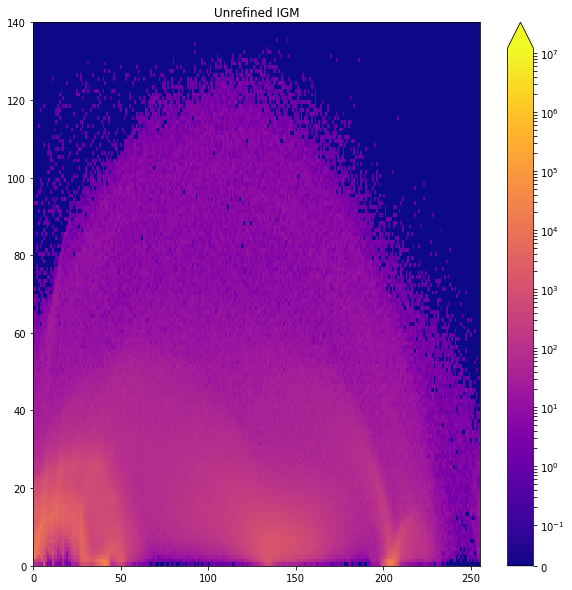

In [12]:
##Useful reference: https://matplotlib.org/3.1.1/tutorials/colors/colormapnorms.html

x = np.linspace(0, f_bins-1, f_bins)
y = np.linspace(0, g_bins-1, g_bins)
z = 1
fig = plt.figure(figsize=(10, 10))

plt.title('Unrefined IGM')
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, igm_bins_2d, 
               norm=colors.SymLogNorm(linthresh = 0.1, 
                                      vmin=igm_bins_2d.min(), 
                                      vmax=igm_bins_2d.max()), 
               cmap='plasma')
plt.colorbar(extend='max')
plt.show()


<ipython-input-13-8ca2b5e7dac8>:5: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm=colors.SymLogNorm(linthresh = 0.1,


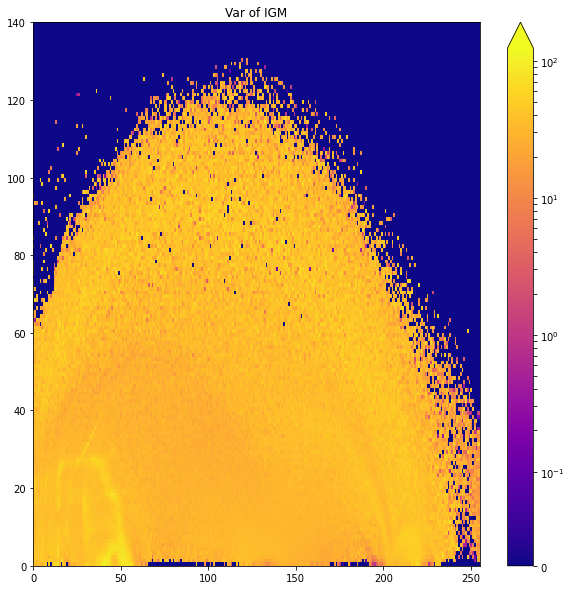

In [13]:
fig = plt.figure(figsize=(10, 10))
plt.title('Var of IGM')
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, var_2d, 
               norm=colors.SymLogNorm(linthresh = 0.1, 
                                      vmin=var_2d.min(), 
                                      vmax=var_2d.max()), 
               cmap='plasma')
plt.colorbar(extend='max')
plt.show()

<ipython-input-14-0cecd8384f50>:5: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm=colors.SymLogNorm(linthresh = 0.1,


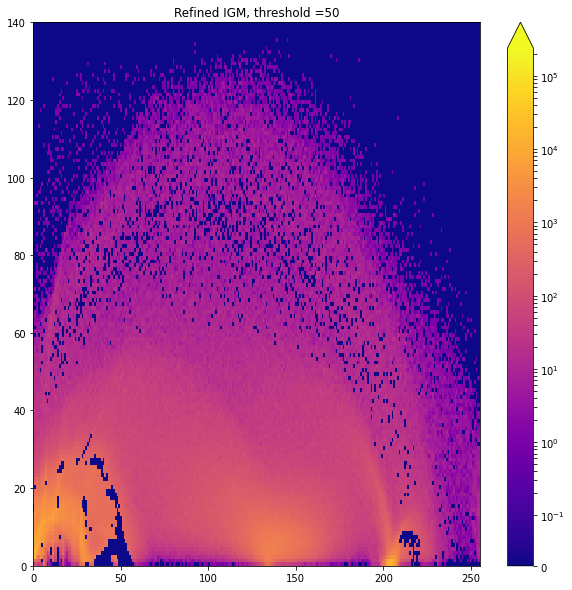

In [14]:

fig = plt.figure(figsize=(10, 10))
plt.title('Refined IGM, threshold =' + str(threshold))
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, igm_refined_2d, 
               norm=colors.SymLogNorm(linthresh = 0.1, 
                                      vmin=igm_refined_2d.min(), 
                                      vmax=igm_refined_2d.max()), 
               cmap='plasma')

plt.colorbar(extend='max')
plt.show()

In [37]:
#First, create our matrix of data - [intensity vs data]
def gen_features_arr(igm_refined_2d, f_num_bins):
    features_arr = np.asarray([[x, y] for y, val in enumerate(igm_refined_2d)
                                                  for x, bins in enumerate(val)
                                                  if bins > 0 ])
    
    voxels_per_bin = np.full((igm_bins.shape[0], igm_bins.shape[0], 3), -1)
    igm_to_features_idx = np.zeros((igm_bins.shape[0]), dtype = np.int)

    igm_to_features_idx = np.asarray([(x+y*f_num_bins) if bins > 0 else -1 for y, val in enumerate(igm_refined_2d)
                                                                            for x, bins in enumerate(val)])
    return features_arr, voxels_per_bin, igm_to_features_idx

    features_arr = []
    i= 0
    j = 0
    for y, val in enumerate(igm_refined_2d):
        for x, bins in enumerate(val):
            igm_to_features_idx[j] = -1
            if (bins > 0):
                features_arr.append([x, y])
                igm_to_features_idx[j] = i
                i = i + 1
            j = j + 1

            #voxels_per_bin.append(np.zeros([bins, 3], dtype=np.int))

    features_arr = np.asarray(features_arr)
    return features_arr, voxels_per_bin, igm_to_features_idx

features_arr, voxels_per_bin, igm_to_features_idx = gen_features_arr(igm_refined_2d, f_bins)
print(features_arr.shape[0])
print(voxels_per_bin.shape, igm_bins.shape)
test = 400
print(igm_to_features_idx[test])
print(igm_refined[test])
print(igm_to_features_idx.max())

24394
(36096, 36096, 3) (36096,)
400
335
36030


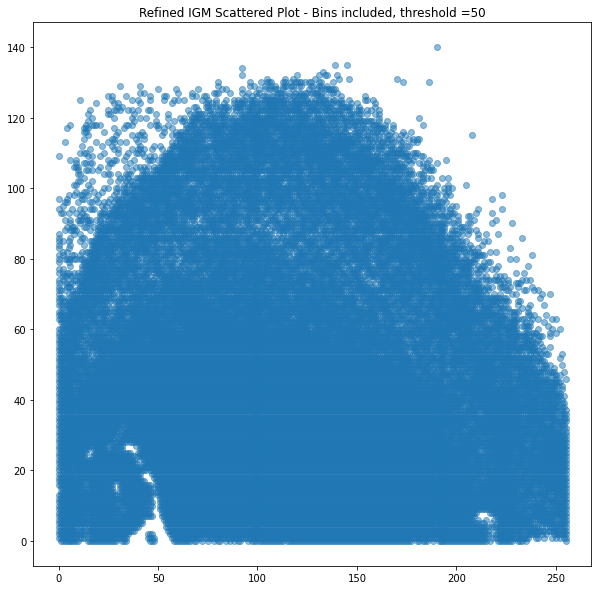

In [16]:
fig = plt.figure(figsize=(10, 10))
plt.title('Refined IGM Scattered Plot - Bins included, threshold =' + str(threshold))
#X, Y = np.meshgrid(x, y)
plt.scatter(features_arr[:, 0], features_arr[:, 1], alpha=0.5)
plt.show()

In [18]:
@cuda.jit
def setIGM_Matrix(row_arr, feature_arr, num_bins):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    row_id = cuda.blockIdx.y*cuda.blockDim.y
    
    #if (i == 0):
    #    print(row_id)
    if (i >= num_bins or row_id >= num_bins):
        return
    
    #Do the similary between this thread and the row id
    bxi = feature_arr[row_id][0]
    bxg = feature_arr[row_id][1]
    
    byi = feature_arr[i][0]
    byg = feature_arr[i][1]
    
    row_arr[row_id][i] = math.sqrt(float(pow(bxi - byi,2) + pow(bxg - byg,2)))
    
    
@cuda.jit
def normalizeIGM_Matrix(row_arr, sIGM_min, sIGM_range, num_bins):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    row_id = cuda.blockIdx.y*cuda.blockDim.y
    
    #if (i == 0):
    #    print(row_id)
    if (i >= num_bins or row_id >= num_bins):
        return
    
    
    row_arr[row_id][i] = (row_arr[row_id][i] - sIGM_min)/(sIGM_range)

def calcSIGM_Matrix(features_arr):
    sIGM_matrix = np.zeros([features_arr.shape[0], features_arr.shape[0]], dtype = np.float32)
    
    num_bins = features_arr.shape[0]
    
    #Figure out launch configuration
    #Launch a thread for every row
    blockSize = 256
    gridX = iDivUp(features_arr.shape[0], blockSize) #Numer of blocks for a row
    gridY = num_bins                #Create gridY gridX's for each row
    gridSize  = gridX, gridY
    
    print(gridX, gridY)
    
    start_time = timeit.default_timer()
 
    #Launch a 2D grid where each thread is working on a specific row and item
    setIGM_Matrix[gridSize, blockSize](sIGM_matrix, features_arr, num_bins)
       
    elapsed = timeit.default_timer() - start_time
    print("here", elapsed)
    
    start_time = timeit.default_timer()
    #now normalize the matrix
    sIGM_max = sIGM_matrix.max()
    sIGM_min = sIGM_matrix.min()
    sIGM_range = sIGM_max - sIGM_min
    
    normalizeIGM_Matrix[gridSize, blockSize](sIGM_matrix, sIGM_min, sIGM_range, num_bins)
    
    
    
    #sIGM_matrix = (sIGM_matrix - sIGM_min)/(sIGM_range)
    elapsed = timeit.default_timer() - start_time
    print("done", elapsed)
    
    return sIGM_matrix
        

In [25]:
@cuda.reduce
def sum_reduce(a, b):
    return a+b


#Two voxels are neighbours if any of their coordinates is one
#unit apart
@cuda.jit(device=True)
def isNeighbour(X, Y):
    dX = abs(X[0] - Y[0])
    dY = abs(X[1] - Y[1])
    dZ = abs(X[2] - Y[2])
    
    if (X[0] == -1 or Y[0] == -1):
        print("oops!")
        
    if (dX == 1 or dY == 1 or dZ == 1):
        if (dX <= 1 and dY <= 1 and dZ <= 1):
            return 1
    return 0


@cuda.jit
def normalizeSVOL_Matrix(sVOL_matrix, neigh_sums, num_bins):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    row_id = cuda.blockIdx.y*cuda.blockDim.y    

    if (i >= num_bins or row_id >= num_bins):
        return
    
    bx = neigh_sums[row_id] 
    by = neigh_sums[i]
    
    if (bx == 0 or by == 0):
        sVOL_matrix[row_id][i] = 0
        return
    
    sVOL_matrix[row_id][i] = max(sVOL_matrix[row_id][i]/bx, sVOL_matrix[i][row_id]/by)
    
@cuda.jit
def setSVol_Matrix(sVOL_matrix, features_arr, voxel_bins, num_bins, f_num_bins):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    row_id = cuda.blockIdx.y*cuda.blockDim.y    

    if (i >= num_bins or row_id >= num_bins):
        return
    
    #i is the column, row_id is the row
    #We want to compare the voxels in i to the voxels in row_id
    row_int  = features_arr[row_id][0]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
    row_grad = features_arr[row_id][1]
    
    col_int  = features_arr[i][0]
    col_grad = features_arr[i][1]
    
    neigh_count = 0
    
    #for voxelX in voxel_bins[row_int + f_num_bins*row_grad]:
    #    if (voxelX[0] == -1):
    #        break
    #    for voxelY in voxel_bins[col_int + f_num_bins*col_grad]:
    #        if (voxelY[0] == -1):
    #            continue
    #        ##are they neighbours
    #        neigh_count = neigh_count + isNeighbour(voxelX, voxelY)
            
    sVOL_matrix[row_id][i] = neigh_count
      
@cuda.jit
def populateVoxelsInBin(voxels_in_bin, igm_refined, data_ptr, grad_mag_ptr, 
                        data_bin_ptr, f_bin_min, g_bin_min,
                        f_num_bins, g_num_bins, data_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    f_val = data_ptr[i][j][k]     - f_bin_min
    g_val = grad_mag_ptr[i][j][k] - g_bin_min
    
    f_loc = int(f_val/f_bin_size)
    g_loc = int(g_val/g_bin_size)   
    
    ##TODO check this if there's a problem
    loc   = f_loc + f_num_bins*g_loc
       
    

    
    if (igm_refined[loc] > 0) :
        ##Is this voxel in a non-zero bin
        if (loc == 0):
            print(i, j, k, igm_refined[loc])
        pos = data_bin_ptr[i][j][k]
        voxels_in_bin[loc][pos][0] = i
        voxels_in_bin[loc][pos][1] = j
        voxels_in_bin[loc][pos][2] = k
    
##Now figure out the spatial similarity matrix
def calcSVOL_Matrix(features_arr, igm_refined, voxels_in_bin, igm_size, data_ptr, grad_mag_ptr, 
                    fval_min, gval_min, f_num_bins, g_num_bins, data_size):
    num_bins = features_arr.shape[0]
    sVOL_matrix = np.zeros([num_bins, num_bins], dtype = np.float32)
    
 
    ###########################################
    #Get the voxels each bin contains first
    ###########################################
    #Launch a thread per voxel
    blockSize = 8, 8, 8
    gridSize  = iDivUp(data_size[0], 8), iDivUp(data_size[1], 8), iDivUp(data_size[2], 8)
    
    start_time = timeit.default_timer()
    
    #for i, bin_item in enumerate(features_arr):
    populateVoxelsInBin[gridSize, blockSize](voxels_in_bin, igm_refined, data_ptr, grad_mag_ptr, 
                          data_bin_ptr, fval_min, gval_min, f_num_bins, g_num_bins, data_size)
        
    cuda.synchronize()
    elapsed = timeit.default_timer() - start_time
    print("Time elapsed", elapsed)
    
    ##Now setup the sVOL_matrix
    #Launch a thread for every row
    blockSize = 256
    gridX = iDivUp(features_arr.shape[0], blockSize) #Numer of blocks for a row
    gridY = num_bins                #Create gridY gridX's for each row
    gridSize  = gridX, gridY    
    
    start_time = timeit.default_timer()
 
    #Launch a 2D grid where each thread is working on a specific row and voxel
    setSVol_Matrix[gridSize, blockSize](sVOL_matrix, features_arr, voxels_in_bin, igm_to_feature_idx, 
                                        num_bins, f_num_bins)
       
    elapsed = timeit.default_timer() - start_time
    print("2. Time elapsed", elapsed)   
    
    
    #Sum each row
    start_time = timeit.default_timer()

    neigh_sums = np.asarray([sum_reduce(item) for item in sVOL_matrix])
    print(neigh_sums.shape)
    
    ##Now get the normalized similarity matrix
    normalizeSVOL_Matrix[gridSize, blockSize](sVOL_matrix, neigh_sums, num_bins)
    print("3. Time elapsed", elapsed)   

    
    return sVOL_matrix, voxels_in_bin


In [23]:
sIGM_matrix = calcSIGM_Matrix(features_arr)
print(sIGM_matrix)
print(f_bin_size)
print(features_arr)

96 24394
here 2.0063239922747016
done 0.8933996092528105
[[0.         0.00360595 0.0072119  ... 0.69613546 0.71176225 0.8481348 ]
 [0.00360595 0.         0.00360595 ... 0.6935624  0.70913583 0.84524   ]
 [0.0072119  0.00360595 0.         ... 0.69099855 0.7065181  0.8423506 ]
 ...
 [0.69613546 0.6935624  0.69099855 ... 0.         0.02163571 0.18478523]
 [0.71176225 0.70913583 0.7065181  ... 0.02163571 0.         0.1632664 ]
 [0.8481348  0.84524    0.8423506  ... 0.18478523 0.1632664  0.        ]]
1
[[  1   0]
 [  2   0]
 [  3   0]
 ...
 [139 135]
 [145 135]
 [190 140]]


In [26]:
sVOL_matrix, voxels_per_bin = calcSVOL_Matrix(features_arr, igm_refined, voxels_per_bin, f_bins*g_bins, data_ptr, 
                                              grad_mag_ptr, fval_min, gval_min, f_bins, g_bins, data_size)
#print(sVOL_matrix)
print(voxels_per_bin[1])
print(igm_refined[1])

Time elapsed 7.368466234765947
2. Time elapsed 9.136474951170385
(24394,)
3. Time elapsed 9.136474951170385
[[148 167  23]
 [181 105  32]
 [182 105  32]
 ...
 [ -1  -1  -1]
 [ -1  -1  -1]
 [ -1  -1  -1]]
93


In [ ]:
@cuda.jit
def populateSimilarityMatrix(sIGM_matrix, sVOL_matrix, k1, k2, num_bins):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    row_id = cuda.blockIdx.y*cuda.blockDim.y    

    if (i >= num_bins or row_id >= num_bins):
        return   

    sIGM_matrix[row_id][i] = k1*sIGM_matrix[row_id][i] + k2*sVOL_matrix[row_id][i]

def setSimilarityMatrix(sIGM_matrix, sVOL_matrix, k1 = 0.65, k2 = 0.35):
    start_time = timeit.default_timer()
    #similarityMatrix = k1*sIGM_matrix + k2*sVOL_matrix   
    
    num_bins = sIGM_matrix.shape[0]
    
    ##Now setup the sVOL_matrix
    #Launch a thread for every row
    blockSize = 256
    gridX = iDivUp(features_arr.shape[0], blockSize) #Numer of blocks for a row
    gridY = num_bins                #Create gridY gridX's for each row
    gridSize  = gridX, gridY    
    
    start_time = timeit.default_timer()
 
    #Launch a 2D grid where each thread is working on a specific row and item
    populateSimilarityMatrix[gridSize, blockSize](sIGM_matrix, sVOL_matrix, k1, k2, num_bins)
       
    elapsed = timeit.default_timer() - start_time
    
    print("Time elapsed", elapsed)   
    return sIGM_matrix


In [ ]:
similarityMatrix = setSimilarityMatrix(sIGM_matrix, sVOL_matrix, k1 = 0.65, k2 = 0.35)

In [ ]:
##Time to do some AP clustering!
#First, let's do the automatic AP clustering method. Later I'll implement the one in the paper
start_time = timeit.default_timer()
af = AffinityPropagation.fit(similarityMatrix, y=None)
cluster_centers_indices = af.cluster_centers_indices_ 
labels = af.labels_ 
  
n_clusters_ = len(cluster_centers_indices) 
print("Time elapsed", elapsed)   

print(labels, n_clusters_)


In [ ]:
#!/usr/bin/env python

# This is a simple volume rendering example that uses a
# vtkGPUVolumeRayCastMapper

'''
import vtk
from vtk.util.misc import vtkGetDataRoot
VTK_DATA_ROOT = vtkGetDataRoot()

# Create the standard renderer, render window and interactor
ren = vtk.vtkRenderer()
renWin = vtk.vtkRenderWindow()
renWin.AddRenderer(ren)
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

# Create the reader for the data
reader = vtk.vtkStructuredPointsReader()
reader.SetFileName(VTK_DATA_ROOT + "/Data/ironProt.vtk")

# Create transfer mapping scalar value to opacity
opacityTransferFunction = vtk.vtkPiecewiseFunction()
opacityTransferFunction.AddPoint(20, 0.0)
opacityTransferFunction.AddPoint(255, 0.2)

# Create transfer mapping scalar value to color
colorTransferFunction = vtk.vtkColorTransferFunction()
colorTransferFunction.AddRGBPoint(0.0, 0.0, 0.0, 0.0)
colorTransferFunction.AddRGBPoint(64.0, 1.0, 0.0, 0.0)
colorTransferFunction.AddRGBPoint(128.0, 0.0, 0.0, 1.0)
colorTransferFunction.AddRGBPoint(192.0, 0.0, 1.0, 0.0)
colorTransferFunction.AddRGBPoint(255.0, 0.0, 0.2, 0.0)

# The property describes how the data will look
volumeProperty = vtk.vtkVolumeProperty()
volumeProperty.SetColor(colorTransferFunction)
volumeProperty.SetScalarOpacity(opacityTransferFunction)
volumeProperty.ShadeOn()
volumeProperty.SetInterpolationTypeToLinear()

# The mapper / ray cast function know how to render the data
volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
volumeMapper.SetBlendModeToComposite()
volumeMapper.SetInputConnection(reader.GetOutputPort())

# The volume holds the mapper and the property and
# can be used to position/orient the volume
volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(volumeProperty)

ren.AddVolume(volume)
ren.SetBackground(1, 1, 1)
renWin.SetSize(600, 600)
renWin.Render()

def CheckAbort(obj, event):
    if obj.GetEventPending() != 0:
        obj.SetAbortRender(1)

    renWin.AddObserver("AbortCheckEvent", CheckAbort)

iren.Initialize()
renWin.Render()
iren.Start()
'''